In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
import math
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from google.colab import files

In [ ]:
# Upload your CSV file
uploaded = files.upload()

# Load data from uploaded CSV
df = pd.read_csv(list(uploaded.keys())[0], parse_dates=['Date'], index_col='Date')

# Display basic information
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

Saving XSD.csv to XSD.csv
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3563 entries, 2006-02-06 to 2020-04-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3563 non-null   float64
 1   High       3563 non-null   float64
 2   Low        3563 non-null   float64
 3   Close      3563 non-null   float64
 4   Adj Close  3563 non-null   float64
 5   Volume     3563 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 194.9 KB
None

First 5 rows:
                 Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2006-02-06  26.424999  26.840000  26.424999  26.709999  24.302902  180000
2006-02-07  26.840000  26.840000  26.645000  26.820000  24.403000  460000
2006-02-08  27.055000  27.330000  26.995001  27.330000  24.867037  475800
2006-02-09  27.610001  27.655001  27.170000  27.170000  24.721455  164200
2006-02-10  27

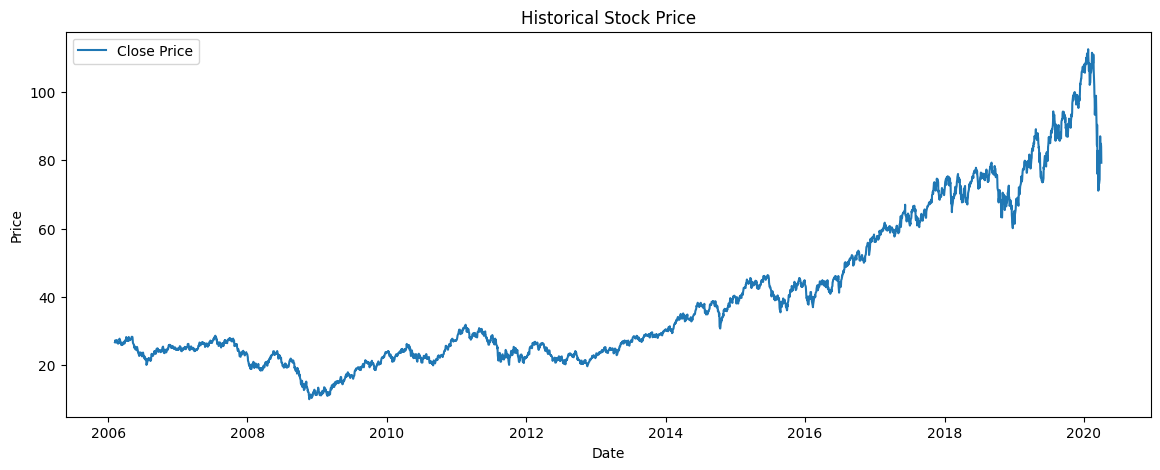

In [ ]:
# Basic visualization of closing prices
plt.figure(figsize=(14,5))
plt.plot(df['Close'], label='Close Price')
plt.title('Historical Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

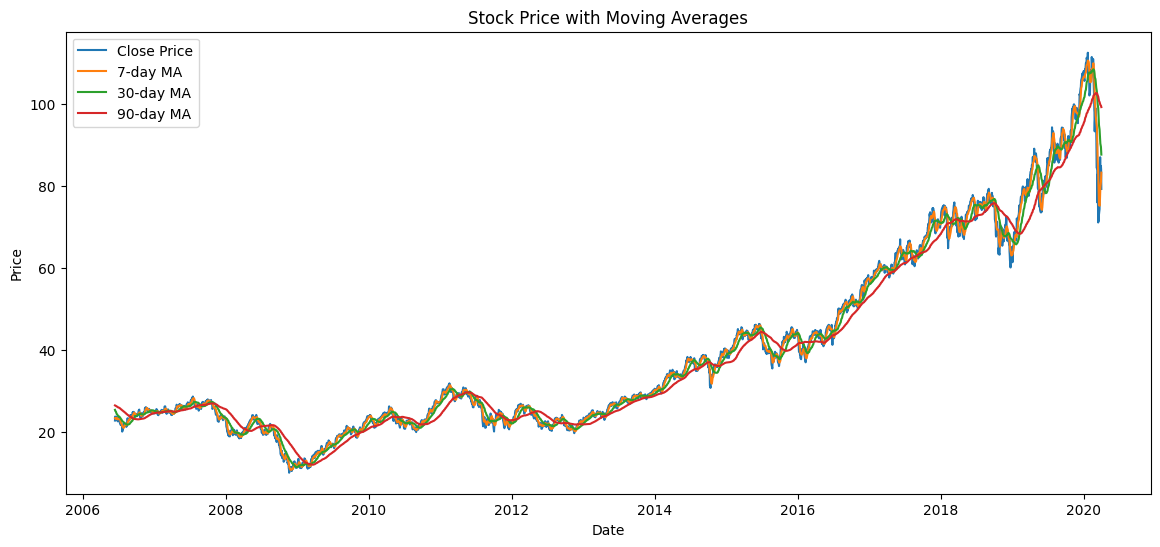

In [ ]:
# Create moving averages
df['MA_7'] = df['Close'].rolling(window=7).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()
df['MA_90'] = df['Close'].rolling(window=90).mean()
df.dropna(inplace=True)

# Visualize moving averages
plt.figure(figsize=(14,6))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['MA_7'], label='7-day MA')
plt.plot(df['MA_30'], label='30-day MA')
plt.plot(df['MA_90'], label='90-day MA')
plt.title('Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close']])

In [ ]:
# Prepare data for different models
# Linear Regression data
lr_data = df.reset_index()[['Date', 'Close']]
lr_data['Date'] = lr_data['Date'].map(pd.Timestamp.toordinal)

# ARIMA data
arima_data = df['Close']

# LSTM data preparation function
def create_dataset(data, window=60):
    X, y = [], []
    for i in range(len(data)-window):
        X.append(data[i:(i+window), 0])
        y.append(data[i+window, 0])
    return np.array(X), np.array(y)

window = 60
X, y = create_dataset(scaled_data, window)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-test split (80-20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
# Linear Regression (Baseline)
lr_model = LinearRegression()
lr_model.fit(lr_data['Date'][:split].values.reshape(-1,1), lr_data['Close'][:split])
lr_pred = lr_model.predict(lr_data['Date'][split:].values.reshape(-1,1))

lr_rmse = math.sqrt(mean_squared_error(lr_data['Close'][split:], lr_pred))
lr_mae = mean_absolute_error(lr_data['Close'][split:], lr_pred)
print(f"Linear Regression - RMSE: {lr_rmse:.2f}, MAE: {lr_mae:.2f}")

Linear Regression - RMSE: 31.38, MAE: 29.51


In [ ]:
# ARIMA Model with frequency handling and NaN check
# Ensure the time series has a defined frequency and handle NaN values
arima_data = df['Close'].asfreq('D')  # Set daily frequency
arima_data = arima_data.fillna(method='ffill')  # Forward fill missing values

# Split data into training and test sets
split = int(0.8 * len(arima_data))
train_data = arima_data[:split]
test_data = arima_data[split:]

# Fit ARIMA model
try:
    arima_model = ARIMA(train_data, order=(5, 1, 0))
    arima_model_fit = arima_model.fit()

    # Forecast
    forecast_steps = len(test_data)
    arima_pred = arima_model_fit.forecast(steps=forecast_steps)

    # Convert prediction to Series with correct index
    arima_pred = pd.Series(arima_pred, index=test_data.index)

    # Calculate metrics
    arima_rmse = math.sqrt(mean_squared_error(test_data, arima_pred))
    arima_mae = mean_absolute_error(test_data, arima_pred)
    print(f"ARIMA Model - RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}")

except Exception as e:
    print(f"An error occurred with the ARIMA model: {e}")

/tmp/ipython-input-9-815087984.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  arima_data = arima_data.fillna(method='ffill')  # Forward fill missing values


ARIMA Model - RMSE: 20.28, MAE: 16.11


In [ ]:
# Build LSTM Model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(window,1)),
    Dropout(0.2),
    LSTM(50),
    Dropout(0.2),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 0.0068
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 5.4193e-04
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 4.5655e-04
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 5.3043e-04
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 4.7216e-04
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 4.8357e-04
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - loss: 3.5321e-04
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 4.0339e-04
Epoch 9/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 2.9215e-04
Epoch 10/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 3.9628e-04
Epoch 11/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 3.2177e-04
Epoch 12/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 3.1805e-04
Epoch 13/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 2.8205e-04
Epoch 14/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 2.5624e-04
Epoch 15/20
86/86 

In [ ]:
# LSTM Prediction
lstm_pred = lstm_model.predict(X_test)
lstm_pred = scaler.inverse_transform(lstm_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

lstm_rmse = math.sqrt(mean_squared_error(y_test_actual, lstm_pred))
lstm_mae = mean_absolute_error(y_test_actual, lstm_pred)
print(f"LSTM Model - RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
LSTM Model - RMSE: 2.79, MAE: 1.95


In [ ]:
# Print detailed diagnostics
print(f"split: {split}")
print(f"window: {window}")
print(f"len(df): {len(df)}")
print(f"split + window: {split + window}")
print(f"len(df.index[split+window:]): {len(df.index[split+window:])}")
print(f"len(y_test_actual): {len(y_test_actual)}")
print(f"len(lstm_pred): {len(lstm_pred)}")
print(f"len(lr_pred): {len(lr_pred)}")
print(f"len(arima_pred): {len(arima_pred)}")

split: 4032
window: 60
len(df): 3474
split + window: 4092
len(df.index[split+window:]): 0
len(y_test_actual): 683
len(lstm_pred): 683
len(lr_pred): 743
len(arima_pred): 1009


In [ ]:
# Plot results comparison
plt.figure(figsize=(14, 8))

# Determine the minimum length to ensure all arrays are the same size
min_length = min(
    len(df.index[split+window:]),
    len(y_test_actual),
    len(lstm_pred),
    len(lr_pred),
    len(arima_pred)
)

# Ensure min_length is at least 1 to avoid empty plots
if min_length < 1:
    print("Not enough data to plot. Check data preparation steps.")
else:
    # Actual prices
    plt.plot(
        df.index[split+window:split+window+min_length],
        y_test_actual[:min_length],
        label='Actual Price'
    )

    # Model predictions
    plt.plot(
        df.index[split+window:split+window+min_length],
        lstm_pred[:min_length],
        label='LSTM Prediction'
    )
    plt.plot(
        df.index[split:split+min_length],
        lr_pred[:min_length],
        label='Linear Regression Prediction'
    )
    plt.plot(
        df.index[split:split+min_length],
        arima_pred[:min_length],
        label='ARIMA Prediction'
    )

    plt.title('Stock Price Prediction Comparison')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

Not enough data to plot. Check data preparation steps.


<Figure size 1400x800 with 0 Axes>

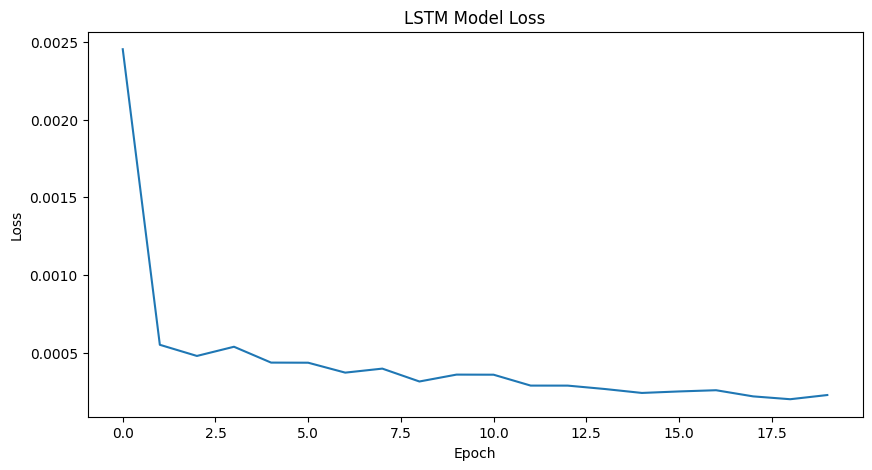

In [ ]:
# Learning curve for LSTM
plt.figure(figsize=(10,5))
plt.plot(lstm_history.history['loss'])
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
print("\nModel Limitations:")
print("- Stock prices are affected by many unpredictable factors")
print("- The model doesn't consider news, financial statements, or other external factors")
print("- Financial markets can be non-stationary and regime shifts can occur")
print("- Past performance is not indicative of future results")


Model Limitations:
- Stock prices are affected by many unpredictable factors
- The model doesn't consider news, financial statements, or other external factors
- Financial markets can be non-stationary and regime shifts can occur
- Past performance is not indicative of future results
